In [ ]:
import requests
import json
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates

In [ ]:
from google.colab import data_table
data_table.disable_dataframe_formatter()

## **1.1 Sub-activity: Open Data COVID-19 API**

### **Task 1**

In [ ]:
# Referenced from the API documentation
def get_API_data(filters, structure):
    endpoint = "https://api.coronavirus.data.gov.uk/v1/data"
    # pack parameters
    api_params = {
        "filters": str.join(";", filters),
        "structure": json.dumps(structure, separators=(",", ":")),
        "page":1
        }
    response = requests.get(endpoint, params=api_params, timeout = 50)  # send request
    
    # running into problem when status_code >=400
    if response.status_code >= 400:
        raise RuntimeError(f'Request failed: { response.text }')
        
    result = response.json()
    return result['data']


### **Task 2**

In [ ]:
query_filters = ['areaType=nation']
# the data we require
query_structure = {
    "date": "date",
    "name": "areaName",
    "daily_cases": "newCasesBySpecimenDate",
    "cumulative_cases": "cumCasesBySpecimenDate",
    "daily_deaths": "newDeaths28DaysByPublishDate",
    "cumulative_deaths": "cumDeaths28DaysByPublishDate",
    "cumulative_vaccinated": "cumPeopleVaccinatedSecondDoseByVaccinationDate",
    "vaccination_age": "vaccinationsAgeDemographics"
}
# get national data
results_json_national = get_API_data(query_filters, query_structure)

query_filters = ['areaType=region'] # change area to region
# get regional data
results_json_regional = get_API_data(query_filters, query_structure)

## **1.2 Sub-activity: Shaping the COVID data into different dataframes**

### **Task 3**

In [ ]:
results_json_all = results_json_national + results_json_regional    # concatenate two list of dict

### **Task 4**

In [ ]:
# transform list into a dataframe
covid_data = pd.json_normalize(results_json_all)    # works in pandas 1.3.5

### **Task 5**

In [ ]:
england_rows = covid_data.loc[covid_data['name']=='England']    # select rows with name==England
covid_data=covid_data.drop(england_rows.index)  # drop these rows

### **Task 6**

In [ ]:
covid_data = covid_data.rename(columns={'name': 'area'})    # change column name from 'name' to 'area'
covid_data

,date,area,daily_cases,cumulative_cases,daily_deaths,cumulative_deaths,cumulative_vaccinated,vaccination_age
722,2022-01-20,Northern Ireland,NaN,NaN,2.0,3056.0,NaN,[]
723,2022-01-19,Northern Ireland,4180.0,496038.0,6.0,3054.0,NaN,[]
724,2022-01-18,Northern Ireland,4815.0,491858.0,6.0,3048.0,NaN,[]
725,2022-01-17,Northern Ireland,5048.0,487043.0,4.0,3042.0,NaN,[]
726,2022-01-16,Northern Ireland,3780.0,481995.0,3.0,3038.0,NaN,[]
...,...,...,...,...,...,...,...,...
7078,2020-03-01,South West,3.0,5.0,NaN,NaN,NaN,[]
7079,2020-02-29,South West,0.0,2.0,NaN,NaN,NaN,[]
7080,2020-02-28,South West,0.0,2.0,NaN,NaN,NaN,[]
7081,2020-02-27,South West,1.0,2.0,NaN,NaN,NaN,[]


### **Task 7**  

In [ ]:
covid_data['date'] = covid_data['date'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))    # convert to datetime type

In [ ]:
covid_data.dtypes

date                     datetime64[ns]
area                             object
daily_cases                     float64
cumulative_cases                float64
daily_deaths                    float64
cumulative_deaths               float64
cumulative_vaccinated           float64
vaccination_age                  object
dtype: object

### **Task 8**  
I consider the data a missing value if the data is NaN. 'date' column and 'area' colume don't have missing data so these two columns are not mentioned in the summary below. Column vaccination age contains empty lists. I didn't take them as missing values at this stage.

In [ ]:
# check nan data using isnull()
print('number of missing data in \'daily_cases\': ',covid_data['daily_cases'].isnull().sum())
print('number of missing data in \'cumulative_cases\': ',covid_data['cumulative_cases'].isnull().sum())
print('number of missing data in \'daily_deaths\': ',covid_data['daily_deaths'].isnull().sum())
print('number of missing data in \'cumulative_deaths\': ',covid_data['cumulative_deaths'].isnull().sum())
print('number of missing data in \'cumulative_vaccinated\': ',covid_data['cumulative_vaccinated'].isnull().sum())
print('number of missing data in \'vaccination_age\': ',covid_data['vaccination_age'].isnull().sum())
print('number of missing data in total: ', covid_data.isnull().sum().sum())

number of missing data in 'daily_cases':  10
number of missing data in 'cumulative_cases':  11
number of missing data in 'daily_deaths':  1160
number of missing data in 'cumulative_deaths':  1131
number of missing data in 'cumulative_vaccinated':  3341
number of missing data in 'vaccination_age':  0
number of missing data in total:  5653


### **Task 9**

In [ ]:
comulative_columns = ('cumulative_cases', 'cumulative_deaths', 'cumulative_vaccinated')
for i in comulative_columns:
    # groupby area so that the replacing value is in the same area. 'bfill' means finding value from the back 
    covid_data[i] = covid_data.groupby('area', as_index=False)[i].fillna(method='bfill')
covid_data

,date,area,daily_cases,cumulative_cases,daily_deaths,cumulative_deaths,cumulative_vaccinated,vaccination_age
722,2022-01-20,Northern Ireland,NaN,496038.0,2.0,3056.0,33197.0,[]
723,2022-01-19,Northern Ireland,4180.0,496038.0,6.0,3054.0,33197.0,[]
724,2022-01-18,Northern Ireland,4815.0,491858.0,6.0,3048.0,33197.0,[]
725,2022-01-17,Northern Ireland,5048.0,487043.0,4.0,3042.0,33197.0,[]
726,2022-01-16,Northern Ireland,3780.0,481995.0,3.0,3038.0,33197.0,[]
...,...,...,...,...,...,...,...,...
7078,2020-03-01,South West,3.0,5.0,NaN,NaN,NaN,[]
7079,2020-02-29,South West,0.0,2.0,NaN,NaN,NaN,[]
7080,2020-02-28,South West,0.0,2.0,NaN,NaN,NaN,[]
7081,2020-02-27,South West,1.0,2.0,NaN,NaN,NaN,[]


### **Task 10**

In [ ]:
covid_data = covid_data.dropna()    # drop nan data
covid_data

,date,area,daily_cases,cumulative_cases,daily_deaths,cumulative_deaths,cumulative_vaccinated,vaccination_age
723,2022-01-19,Northern Ireland,4180.0,496038.0,6.0,3054.0,33197.0,[]
724,2022-01-18,Northern Ireland,4815.0,491858.0,6.0,3048.0,33197.0,[]
725,2022-01-17,Northern Ireland,5048.0,487043.0,4.0,3042.0,33197.0,[]
726,2022-01-16,Northern Ireland,3780.0,481995.0,3.0,3038.0,33197.0,[]
727,2022-01-15,Northern Ireland,3036.0,478215.0,0.0,3035.0,33197.0,[]
...,...,...,...,...,...,...,...,...
6792,2020-12-12,South West,666.0,89615.0,36.0,2909.0,996.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
6793,2020-12-11,South West,814.0,88949.0,25.0,2873.0,989.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
6794,2020-12-10,South West,866.0,88135.0,32.0,2848.0,976.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
6795,2020-12-09,South West,818.0,87269.0,28.0,2816.0,950.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."


### **Task 11**

In [ ]:
# first group by area, then assign two new columns. use rolling().mean() to calculate the rolling average.
# rolling window set to 7. min_period=1 so that we can still have a result when we have less than 7 values
covid_data = covid_data.groupby('area', as_index=False).apply(lambda df: df.assign(daily_cases_roll_avg = lambda x: x['daily_cases'].rolling(7, min_periods=1).mean(),
                                                                   daily_deaths_roll_avg = lambda x: x['daily_deaths'].rolling(7, min_periods=1).mean())) 
covid_data

date  ... daily_deaths_roll_avg
0 4212 2022-01-19  ...             27.000000
  4213 2022-01-18  ...             30.500000
  4214 2022-01-17  ...             21.333333
  4215 2022-01-16  ...             17.000000
  4216 2022-01-15  ...             18.000000
...           ...  ...                   ...
9 3893 2020-12-12  ...             46.571429
  3894 2020-12-11  ...             47.714286
  3895 2020-12-10  ...             47.428571
  3896 2020-12-09  ...             48.285714
  3897 2020-12-08  ...             49.571429

[3670 rows x 10 columns]

### **Task 12**

In [ ]:
covid_data = covid_data.drop(['daily_deaths', 'daily_cases'], axis=1)   # drop two columns
covid_data

date  ... daily_deaths_roll_avg
0 4212 2022-01-19  ...             27.000000
  4213 2022-01-18  ...             30.500000
  4214 2022-01-17  ...             21.333333
  4215 2022-01-16  ...             17.000000
  4216 2022-01-15  ...             18.000000
...           ...  ...                   ...
9 3893 2020-12-12  ...             46.571429
  3894 2020-12-11  ...             47.714286
  3895 2020-12-10  ...             47.428571
  3896 2020-12-09  ...             48.285714
  3897 2020-12-08  ...             49.571429

[3670 rows x 8 columns]

### **Task 13**

In [ ]:
# copy date, area, vaccination age to a new dataframe
covid_data_vaccinations = covid_data[['date', 'area', 'vaccination_age']].copy()
covid_data_vaccinations

date  ...                                    vaccination_age
0 4212 2022-01-19  ...  [{'age': '12_15', 'VaccineRegisterPopulationBy...
  4213 2022-01-18  ...  [{'age': '12_15', 'VaccineRegisterPopulationBy...
  4214 2022-01-17  ...  [{'age': '12_15', 'VaccineRegisterPopulationBy...
  4215 2022-01-16  ...  [{'age': '12_15', 'VaccineRegisterPopulationBy...
  4216 2022-01-15  ...  [{'age': '12_15', 'VaccineRegisterPopulationBy...
...           ...  ...                                                ...
9 3893 2020-12-12  ...  [{'age': '12_15', 'VaccineRegisterPopulationBy...
  3894 2020-12-11  ...  [{'age': '12_15', 'VaccineRegisterPopulationBy...
  3895 2020-12-10  ...  [{'age': '12_15', 'VaccineRegisterPopulationBy...
  3896 2020-12-09  ...  [{'age': '12_15', 'VaccineRegisterPopulationBy...
  3897 2020-12-08  ...  [{'age': '12_15', 'VaccineRegisterPopulationBy...

[3670 rows x 3 columns]

In [ ]:
covid_data = covid_data.drop('vaccination_age', axis=1) # drop vaccination age from original dataframe
covid_data

date  ... daily_deaths_roll_avg
0 4212 2022-01-19  ...             27.000000
  4213 2022-01-18  ...             30.500000
  4214 2022-01-17  ...             21.333333
  4215 2022-01-16  ...             17.000000
  4216 2022-01-15  ...             18.000000
...           ...  ...                   ...
9 3893 2020-12-12  ...             46.571429
  3894 2020-12-11  ...             47.714286
  3895 2020-12-10  ...             47.428571
  3896 2020-12-09  ...             48.285714
  3897 2020-12-08  ...             49.571429

[3670 rows x 7 columns]

### **Task 14**

In [ ]:
# explode one row into several rows with data of a specific age group in each row
vac_age_explode = covid_data_vaccinations.explode('vaccination_age')
# split column vaccination age into several columns based on the dict in 'vaccination_age'
vac_age_cols_split = vac_age_explode['vaccination_age'].apply(pd.Series)
# choose the columns we need
cols = [
            vac_age_explode['date'],
            vac_age_explode['area'],
            vac_age_cols_split['age'],
            vac_age_cols_split['VaccineRegisterPopulationByVaccinationDate'],
            vac_age_cols_split['cumPeopleVaccinatedCompleteByVaccinationDate'],
            vac_age_cols_split['newPeopleVaccinatedCompleteByVaccinationDate'],
            vac_age_cols_split['cumPeopleVaccinatedFirstDoseByVaccinationDate'],
            vac_age_cols_split['newPeopleVaccinatedFirstDoseByVaccinationDate'],
            vac_age_cols_split['cumPeopleVaccinatedSecondDoseByVaccinationDate'],
            vac_age_cols_split['newPeopleVaccinatedSecondDoseByVaccinationDate'],
            vac_age_cols_split['cumVaccinationFirstDoseUptakeByVaccinationDatePercentage'],
            vac_age_cols_split['cumVaccinationCompleteCoverageByVaccinationDatePercentage'],
            vac_age_cols_split['cumVaccinationSecondDoseUptakeByVaccinationDatePercentage']
]
# concat these columns together
covid_data_vaccinations_wide = pd.concat(cols, axis=1)
covid_data_vaccinations_wide

date  ... cumVaccinationSecondDoseUptakeByVaccinationDatePercentage
0 4212 2022-01-19  ...                                               11.4       
  4212 2022-01-19  ...                                               48.9       
  4212 2022-01-19  ...                                               67.5       
  4212 2022-01-19  ...                                               64.3       
  4212 2022-01-19  ...                                               67.1       
...           ...  ...                                                ...       
9 3897 2020-12-08  ...                                                0.0       
  3897 2020-12-08  ...                                                0.0       
  3897 2020-12-08  ...                                                0.0       
  3897 2020-12-08  ...                                                0.0       
  3897 2020-12-08  ...                                                0.0       

[48226 rows x 13 columns]

## **Sub-activity: Aggregating, plotting, and analysing**

### **Task 15**

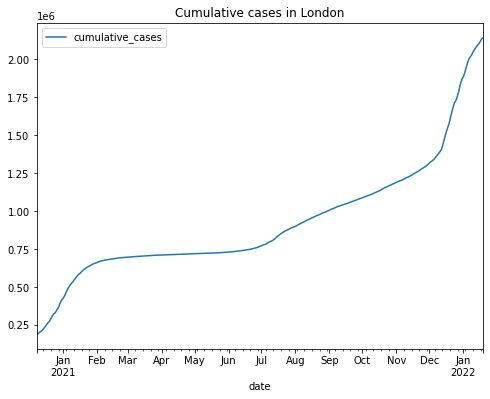

In [ ]:
# select and shape the related data
london_data = covid_data.loc[covid_data['area']=='London']  # find london data
cum_cases_london = london_data[['date', 'cumulative_cases']].set_index('date')

# plot
cum_cases_london.plot(figsize=(8,6), title='Cumulative cases in London')

As shown in the figure, cumulative cases in London plateaued between Feb. 2021 and July 2021.

### **Task 16**

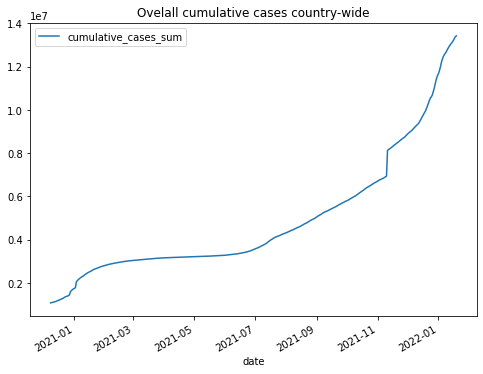

In [ ]:
# select and calculate data
sum_date = covid_data.copy()
# sum the cumulative cases based on date. Create a new column 'cumulative_cases_sum'
sum_date = sum_date.join(sum_date.groupby('date')['cumulative_cases'].sum(), on='date', rsuffix='_sum')
cum_cases_sum = sum_date[['date', 'cumulative_cases_sum']].set_index('date')

# plot
cum_cases_sum.plot(figsize=(8,6), title='Ovelall cumulative cases country-wide')

The figure shows the cumulative cases over all areas contry-wide. The line is not continues because of some nan values in the raw data. By comparing the figure in task 15 and 16, the patterns in London and country-wide are similar. The general trends of the two lines are almost the same.

### **Task 17**

area
East Midlands               AxesSubplot(0.125,0.125;0.775x0.755)
East of England             AxesSubplot(0.125,0.125;0.775x0.755)
London                      AxesSubplot(0.125,0.125;0.775x0.755)
North West                  AxesSubplot(0.125,0.125;0.775x0.755)
Northern Ireland            AxesSubplot(0.125,0.125;0.775x0.755)
Scotland                    AxesSubplot(0.125,0.125;0.775x0.755)
South East                  AxesSubplot(0.125,0.125;0.775x0.755)
South West                  AxesSubplot(0.125,0.125;0.775x0.755)
Wales                       AxesSubplot(0.125,0.125;0.775x0.755)
Yorkshire and The Humber    AxesSubplot(0.125,0.125;0.775x0.755)
Name: cumulative_cases, dtype: object

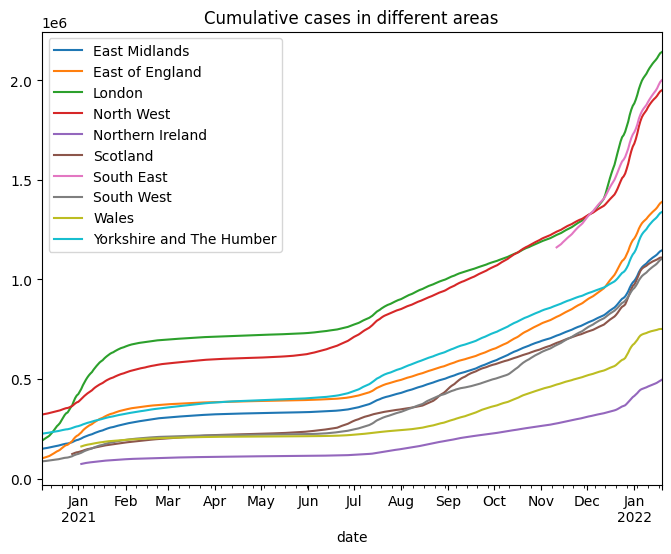

In [ ]:
# select and shape the data
area_cum_cases = covid_data[['date', 'area', 'cumulative_cases']].set_index('date')
# plot
plt.figure(figsize=(8,6), dpi=100)
plt.title('Cumulative cases in different areas')
area_cum_cases.groupby('area').cumulative_cases.plot(legend = True) # group by area then plot

As shown in the figure, the cumulative cases in these areas share the similar patterns although different values are shown in different areas. The cumulative cases in these areas all have been through a stable period from Feb. to Jul. They all started to increase since Aug.

### **Task 18**

In June-July, the UK goverment moved to the Step 4 of their lockdown plan. Most limits on social contact are removed. This action can justify the trend of cumulative cases after July. 

### **Task 19**

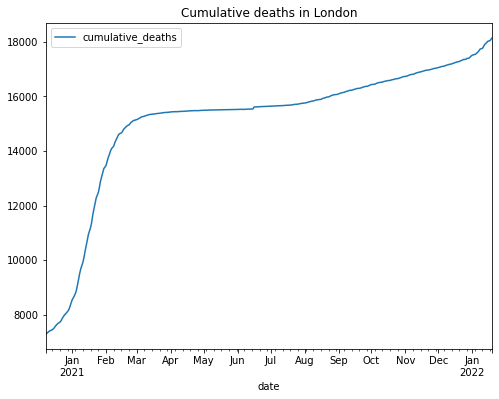

In [ ]:
# select and shape the related data
london_data = covid_data.loc[covid_data['area']=='London']  # select london data
cum_cases_london = london_data[['date', 'cumulative_deaths']].set_index('date')

# plot
cum_cases_london.plot(figsize=(8,6),title='Cumulative deaths in London')

The dramatic increasing trend broke around March 2021. After March the line went stable.

### **Task 20**

Before March 2021, both the number of cumulative cases and cumulative deaths in London are rising. In the period of March 2021 to July 2021, both cumulative cases and cumulative deaths shows a stable trend.

### **Task 21**

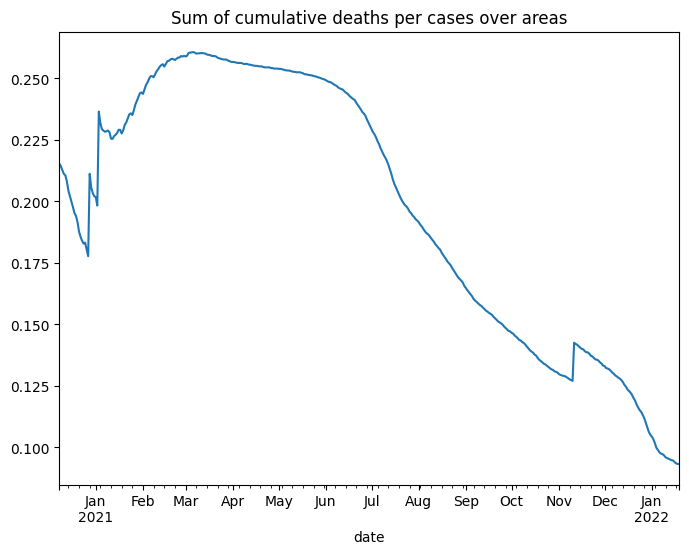

In [ ]:
# data selection and calculation
df = covid_data[['date','area','cumulative_cases','cumulative_deaths']].set_index('date')
# create a new column cumulative deaths per cases
df = df.assign(cumulative_deaths_per_cases=lambda x: round(x.cumulative_deaths/x.cumulative_cases,4))
df = df.groupby('date')['cumulative_deaths_per_cases'].sum()    # sum based on date

# plot
plt.figure(figsize=(8,6), dpi=100)
plt.title('Sum of cumulative deaths per cases over areas')
df.plot()

Since March 2021, the value of the indicator (the sum of cumulative deaths per cases over all areas) has been declining. 

### **Task 22**

A potential explanation is that the vaccination played an important role. Covid became less lethal to human bodies after a large amount of people in th UK get the vaccines.

### **Task 23**

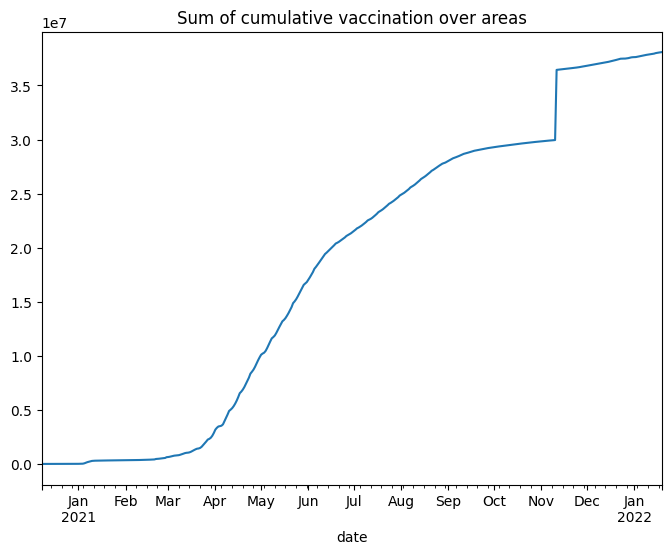

In [ ]:
# data selection and calculation
cum_vaccine = covid_data[['date', 'area', 'cumulative_vaccinated']].set_index('date')
cum_vaccine = cum_vaccine.groupby('date')['cumulative_vaccinated'].sum()    # sum based on date

# plot
plt.figure(figsize=(8,6), dpi=100)
plt.title('Sum of cumulative vaccination over areas')
cum_vaccine.plot()

In the figure in Task 21, there is a trend of declining after March, while in Task 23, the line starts to increase after March. These two lines share an opposite trend.

### **Task 24**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f110da16ad0>,
      dtype=object)

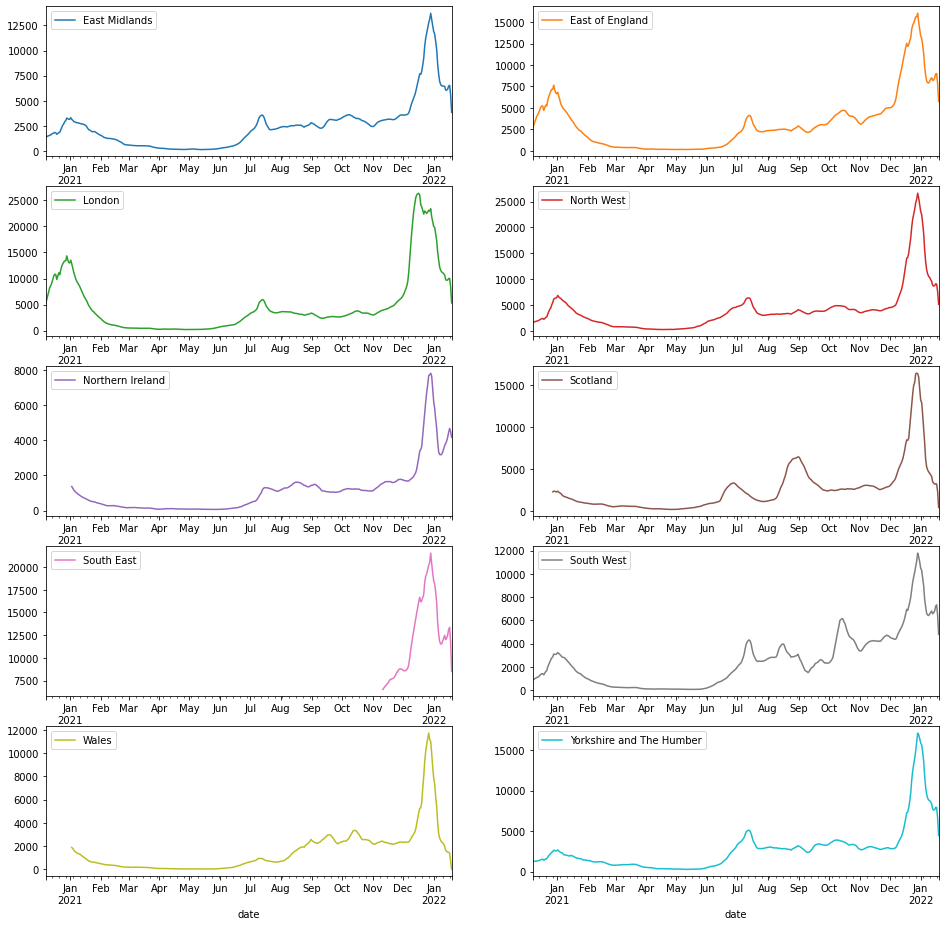

In [ ]:
# select and shape data
df = covid_data[['date', 'area', 'daily_cases_roll_avg']]
# create a pivot table, set date as index, area as column, and daily cases rolling average as value
table = pd.pivot_table(df, columns='area', index='date', values='daily_cases_roll_avg')

# create subplot
table.plot(figsize=(16,16), subplots=True, layout=(5,2),sharex=False)
# table.plot(figsize=(8,6))

Scotland shows a difference in trend compared with other area. The daily cases rolling average reached a small peak at the end of June and quickly went down in Scotland. While in other area, similar small peaks arrived in July amd terbulace is not significant. Scotland also reached a small peak around Sep and quickly went down afterwards. But this peak doesn't exit in most areas with general trend.

### **Task 25**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1110350e10>,
      dtype=object)

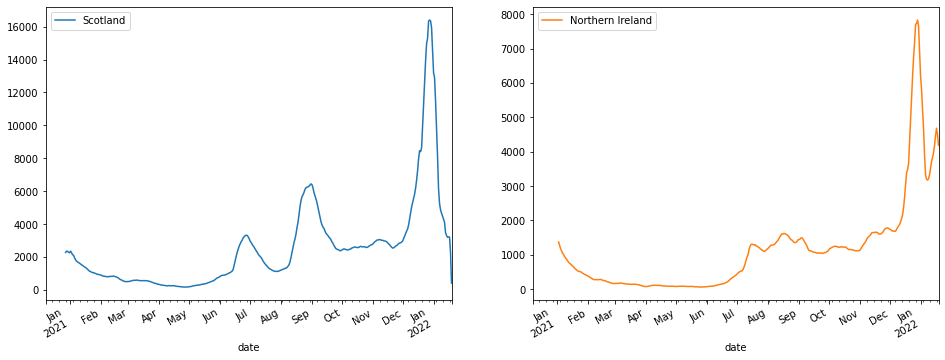

In [ ]:
table[['Scotland', 'Northern Ireland']].plot(subplots=True, layout=(1,2), figsize=(16,6))

Scottish goverment announced rapid test kits to be rolled out to community pharmaices form 9 June, which indicate that the volumn of test was increased. More tests being carried out may be the reason why the average daily rolling cases increased and reached a peak at the end of June . The reason why there is a peak in Sep in Scotland may be colleges in Scotland start earlier than colleges in other areas of UK. Students, college teachers and stuffs gathered together may increase the average dialy rolling cases. In September, several measures were carried out in September by Scotish goverment, including restrictions in high risk venues, increasing vaccines supplies to multiple age groups. Such measures had some positive effect and the average daily rolling cases decreased after Sep. 

### **Task 26**

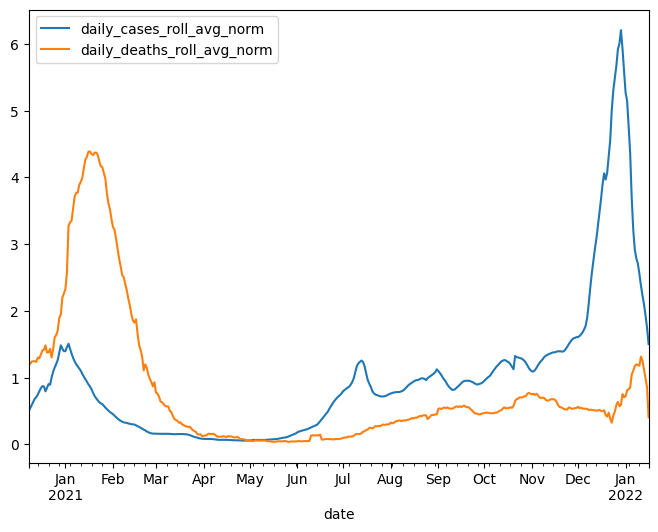

In [ ]:
# data selection and calculation
df = covid_data[['date', 'area', 'daily_cases_roll_avg', 'daily_deaths_roll_avg']].set_index('date')
# find the max values
max_cases = max(df.daily_cases_roll_avg)
max_deaths = max(df.daily_deaths_roll_avg)
# add two new columns
df = df.assign(daily_cases_roll_avg_norm = lambda x: x.daily_cases_roll_avg/max_cases, 
          daily_deaths_roll_avg_norm = lambda x: x.daily_deaths_roll_avg/max_deaths)
# sum based on date
cases_norm_sum = df.groupby('date').daily_cases_roll_avg_norm.sum()
deaths_norm_sum = df.groupby('date').daily_deaths_roll_avg_norm.sum()

# plot
plt.figure(figsize=(8,6), dpi=100)
cases_norm_sum.plot(legend=True)
deaths_norm_sum.plot(legend=True)

Daily trends of cases and deaths don't increase nor decrease at the same rate. Because the two lines in the figure are not parallel (the shapes are not the same).

### **Task 27**

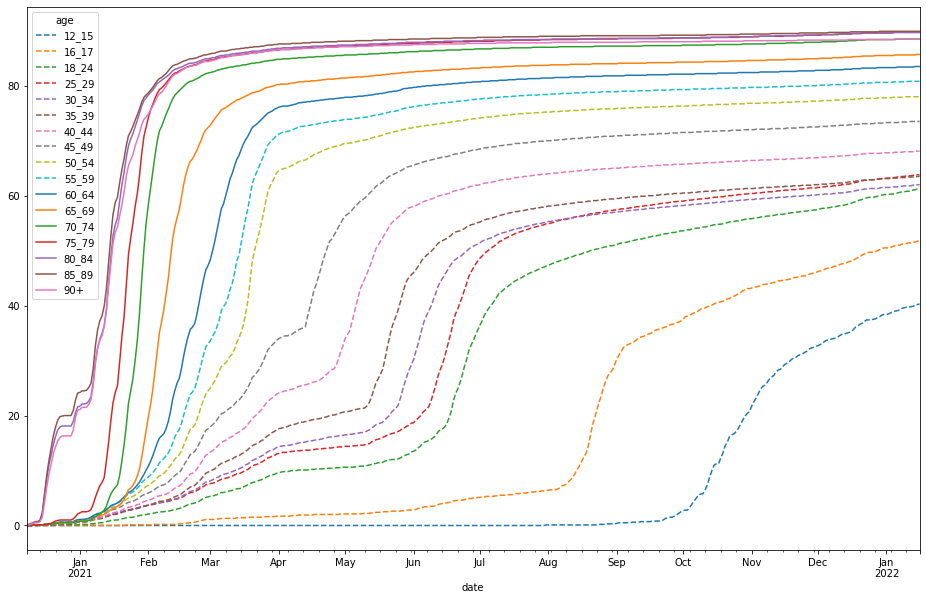

In [ ]:
# Select data for London and Scotland
vaccinations_wide_london = covid_data_vaccinations_wide.loc[covid_data_vaccinations_wide.area=='London']
vaccinations_wide_scotland = covid_data_vaccinations_wide.loc[covid_data_vaccinations_wide.area=='Scotland']

# Transfrom into a pivot table
table = pd.pivot_table(vaccinations_wide_london, index='date', columns='age', values='cumVaccinationFirstDoseUptakeByVaccinationDatePercentage')

# Plot
table.plot(style=['--' for _ in range(10)], figsize=(16,10))

All age groups are not vaccinated equally at the same time. In the figure, curve of high age groups first reaches 80% and becomes stable, which means that vaccines were initially distributed based on age. Older people are given priority to get vaccinated. This strategy was carried out because the virus is more harmfull to older people.

### **Task 28**

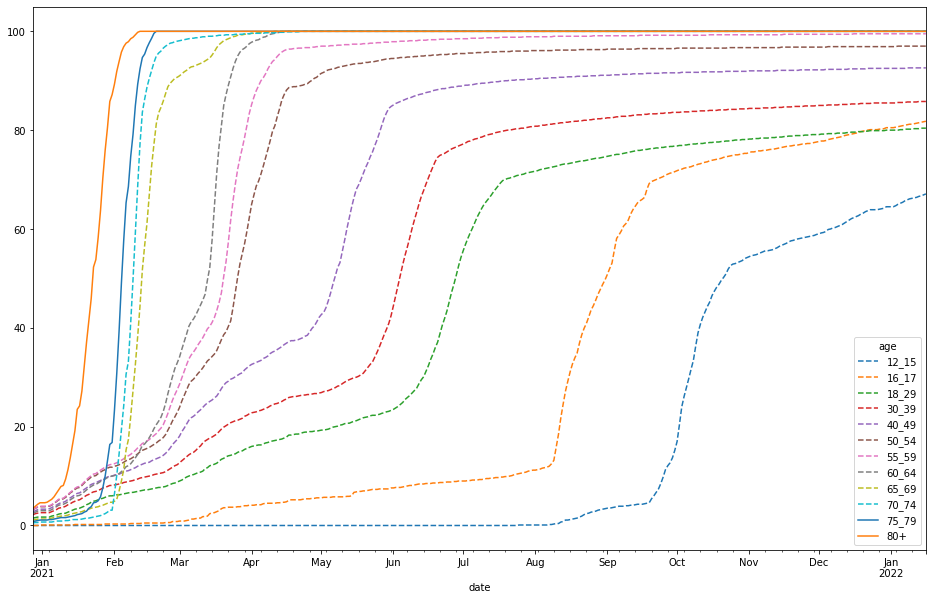

In [ ]:
# Transfrom into a pivot table
table = pd.pivot_table(vaccinations_wide_scotland, index='date', columns='age', values='cumVaccinationFirstDoseUptakeByVaccinationDatePercentage')

# Plot
table.plot(style=['--' for _ in range(10)], figsize=(16,10))

In Scotland, the vaccination percentage of age group 65-79 was lower than the lower age groups before Feb. In fact before Feb, the vaccination percentage of age group 50-64 was higher than other age groups except 80+. The vaccination percentage of age group 65-79 started to rise and overtook those in the lower age groups after Feb.

While in London, the vaccination percentage of age group 65-79 was higher than age group 50-64 and other lower age groups since the middle of Jan.

We can see that the vaccination plan of age group 65-79 might be intentionally delayed befor Feb.